# ECS708P Audio Detection and Analysis Machine Learning Project

The aim of this project is the application of machine learning techniques to the real-world problem of audio detection and analysis.

### Project introduction
The class contained 184 students, each of whom was required to make a series of voice recordings saying a series of numbers, which are shown below. The participant had to take a recording in four different intonations/tones, which were then catergorised accordingly. The different tones used were "question", "neutral", "bored" and "excited".

In the first section, different audio features are extracted and processed, including MFCCs, zero crossing rates and spectral centroids. A basic solution used a variety of classification models to predict the intontation of audio sequences.

An advanced solution was created, using neural networks to try and match the voice to the participant. Four different neural networks were trained and validated, with the optimal neural network able to successfully predict the participant from the class 35% of the time. 

Due to the time taken to load the dataset, only 5000 recordings were used with 4000 used in training and 1000 in validation. The model's quality is demonstrated by its accuracy of 35% out of a class of 184.

1. **Section 1:** Pre-processing and feature extraction

2. **Section 2:** Basic solution

3. **Section 3:** Advanced solution

In [27]:
# Importing packages
from google.colab import drive

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder, minmax_scale
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB


import os, sys, re, pickle, glob
import urllib.request
import zipfile

import IPython.display as ipd
from tqdm import tqdm
import librosa
import librosa.display

drive.mount('/content/drive')

import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [28]:
path = '/content/drive/MyDrive/Data/MLEnd'
os.listdir(path)

files = glob.glob('/content/drive/MyDrive/Data/MLEnd/training/*/*.wav')



# Section 1: Pre-processing and feature extraction

The following features were extracted from the audio files. 
* MFCCs
* Zero Crossing Rate
* Spectral Centroid
* Spectral Rolloff
* Chroma Frequencies

### Plotting the audio

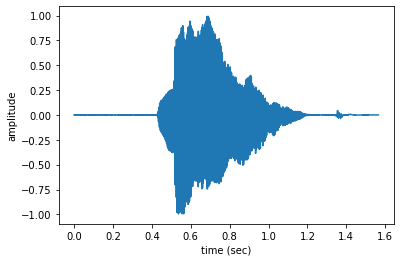

In [29]:
n=0
fs = None 
x, fs = librosa.load(files[n],sr=fs)
t = np.arange(len(x))/fs
plt.plot(t,x)
plt.xlabel('time (sec)')
plt.ylabel('amplitude')
plt.show()
display(ipd.Audio(files[n]))

### Encoding of intonations
The intonation of each associated audiofile was encoded.

In [30]:
labels = pd.read_csv('/content/drive/MyDrive/Data/MLEnd/trainingMLEnd.csv')

le = LabelEncoder()
labels['intonation_label'] = le.fit_transform(labels['intonation'])

# Dictionary mapping of label encoding
le_label_mapping=dict(zip(le.transform(le.classes_), le.classes_))
le_label_mapping

labels.head()

,File ID,digit_label,participant,intonation,intonation_label
0,0000000.wav,4,S73,question,3
1,0000001.wav,2,S88,excited,1
2,0000002.wav,70,S5,neutral,2
3,0000003.wav,2,S85,bored,0
4,0000004.wav,4,S30,excited,1


In [31]:
# Digits used in recordings
sorted(labels['digit_label'].unique())

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 30,
 40,
 50,
 60,
 70,
 80,
 90,
 100,
 1000,
 1000000,
 1000000000]

#### Label encoding dictionary

In [32]:
le_label_mapping

{0: 'bored', 1: 'excited', 2: 'neutral', 3: 'question'}

## Pre-feature extraction
### MFCC features

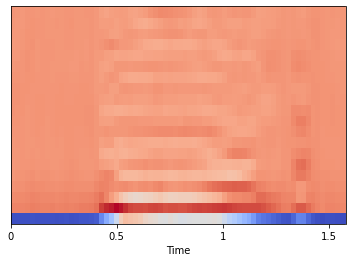

In [33]:
mfccs = librosa.feature.mfcc(x, sr=fs)
# MFCC visualisation
librosa.display.specshow(mfccs, sr=fs, x_axis='time');


### Zero crossing rate

Zero crossing rate is the rate at which the signal crosses from a positive signal to a negative signal or from a negative signal to a postive one. The plot an audio signal is given below.

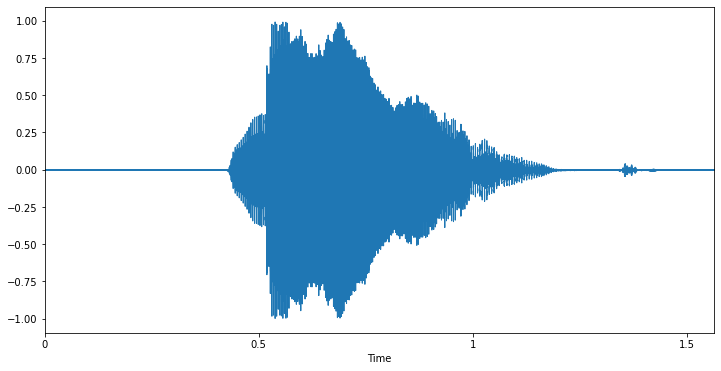

In [34]:
# audio signal visualisation
plt.figure(figsize=(12,6))
librosa.display.waveplot(x, sr=fs)

A small section of this audio wave is sliced and shown below. You can see here that the signal crosses 3 times across the slice of 50 points.

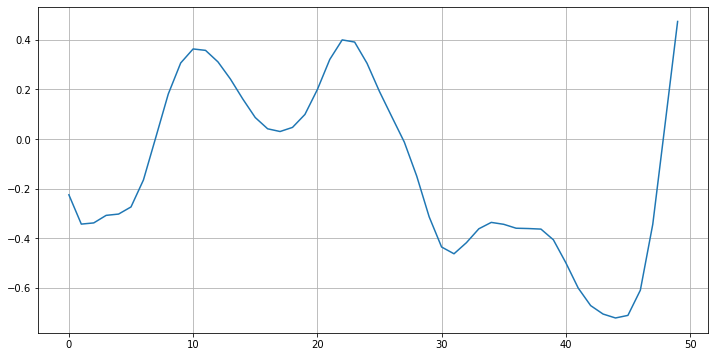

In [35]:
plt.figure(figsize=(12,6))
zcr1, zcr2 = 15000,15050
plt.plot(x[zcr1:zcr2])
plt.grid()


### Spectral Centroid
The spectral centroid is the weighted mean of the frequencies in the signal.

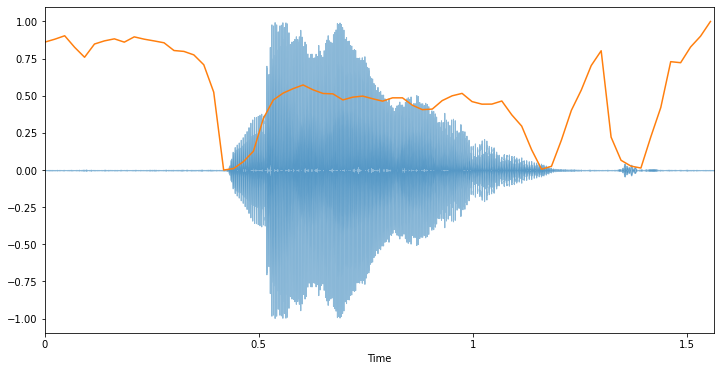

In [36]:
spec_centroids = librosa.feature.spectral_centroid(x, sr=fs)[0]

plt.figure(figsize=(12,6))

f_range = range(len(spec_centroids))
t = librosa.frames_to_time(f_range)

def norm(x, axis=0):
    return minmax_scale(x, axis=axis)

# Visualisation of spectral centroid
librosa.display.waveplot(x, sr=fs, alpha=0.5)

plt.plot(t, norm(spec_centroids))


### Spectral Rolloff

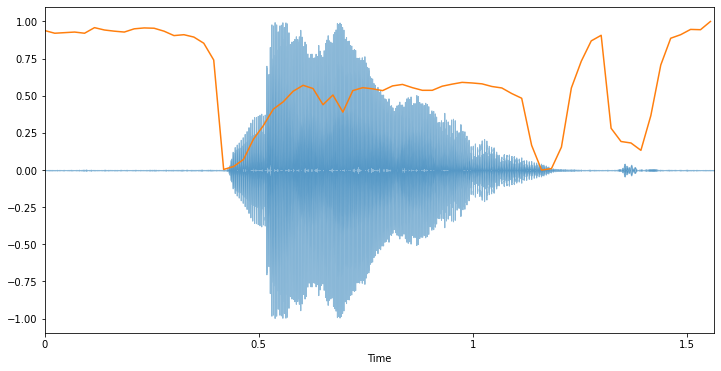

In [37]:
plt.figure(figsize=(12,6))
spec_rolloff = librosa.feature.spectral_rolloff(x, sr=fs)[0]
librosa.display.waveplot(x, sr=fs, alpha=0.5)
plt.plot(t, norm(spec_rolloff))


### Chroma frequencies 

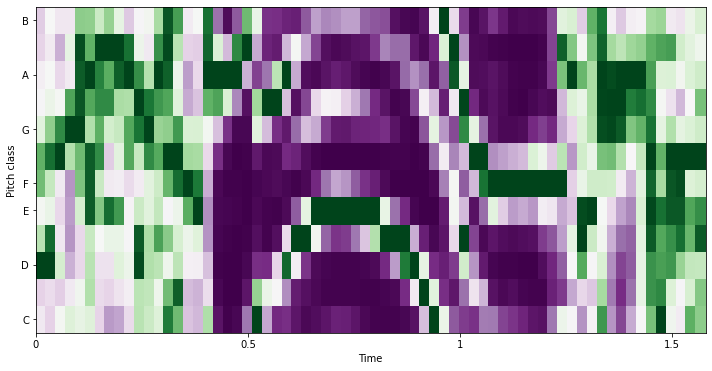

In [38]:
chromagram = librosa.feature.chroma_stft(x, sr=fs)
plt.figure(figsize=(12, 6))

# chromagram visualisation
librosa.display.specshow(chromagram, x_axis='time', y_axis='chroma', cmap='PRGn')

In [39]:
def getPitch(x,fs,winLen=0.02):
  #winLen = 0.02 
  p = winLen*fs
  frame_length = int(2**int(p-1).bit_length())
  hop_length = frame_length//2
  f0, voiced_flag, voiced_probs = librosa.pyin(y=x, fmin=80, fmax=450, sr=fs,
                                                 frame_length=frame_length,hop_length=hop_length)
  return f0,voiced_flag

In [40]:
def getXy(files,labels_file,scale_audio=False, onlySingleDigit=False):
  X,y =[],[]
  for file in tqdm(files):
    fileID = file.split('/')[-1]
    yi = list(labels_file[labels_file['File ID']==fileID]['intonation_label'])[0]
    if onlySingleDigit and yi>9:
      continue
    else:
      fs = None # if None, fs would be 22050
      x, fs = librosa.load(file,sr=fs)
      if scale_audio: x = x/np.max(np.abs(x))
      f0, voiced_flag = getPitch(x,fs,winLen=0.02)
      
      power = np.sum(x**2)/len(x)
      pitch_mean = np.nanmean(f0) if np.mean(np.isnan(f0))<1 else 0
      pitch_std  = np.nanstd(f0) if np.mean(np.isnan(f0))<1 else 0
      voiced_fr = np.mean(voiced_flag)

      # zero crossing rate
      z_crossings = librosa.zero_crossings(x, pad=False)
      zc_rate = sum(z_crossings)/len(x)

      # MFCCs
      mfccs = np.mean(librosa.feature.mfcc(x, sr=fs))

      # spectral centroids
      spec_centroids = np.mean(librosa.feature.spectral_centroid(x, sr=fs))

      # spectral rolloff
      spec_rolloff = np.mean(librosa.feature.spectral_rolloff(x, sr=fs))
      
      # chroma freqs
      chromagram = np.mean(librosa.feature.chroma_stft(x, sr=fs))

      xi = [power,pitch_mean,pitch_std,voiced_fr, zc_rate, mfccs, spec_centroids, spec_rolloff, chromagram]
      X.append(xi)
      y.append(yi)
  return np.array(X),np.array(y)

In [41]:
Xb1,yb1 = getXy(files[:500],labels_file=labels,scale_audio=True, onlySingleDigit=True)

# If you want to use all 20000 files, run next line instead
# X,y = getXy(files,labels_file=labels,scale_audio=True, onlySingleDigit=True)

100%|██████████| 500/500 [03:59<00:00,  2.09it/s]


In [42]:
X_copy = Xb1.copy()
y_copy = yb1.copy()

# Section 2: Basic solution

A number of different classifiers were investigated to see the affect on the accuracy. The classifiers considered were:
* Support Vector Machines
* Naive Bayes classification
* Logistic regression
* Random Forest classification



The features and labels were put into a dataframe, as shown below.

In [43]:
features_df = pd.DataFrame(np.column_stack([Xb1,yb1]))
features_df.columns=['power','pitch_mean','pitch_std','voiced_fr', 
                     'zc_rate','mfccs', 'spec_centroids', 'spec_rolloff', 'chromagram', 'intonation_label']
features_df.intonation_label = features_df.intonation_label.astype('int64')
features_df.head()

,power,pitch_mean,pitch_std,voiced_fr,zc_rate,mfccs,spec_centroids,spec_rolloff,chromagram,intonation_label
0,0.028636,252.507043,58.852188,0.503704,0.080730,-18.196531,1666.780588,3794.118724,0.434165,1
1,0.019146,244.162956,91.534801,0.327103,0.083100,-9.426552,2327.077190,4790.340169,0.519815,3
2,0.061597,178.626050,8.016854,0.663158,0.058137,-12.321603,1772.748383,3875.079346,0.280043,2
3,0.022428,173.763780,24.505713,0.482353,0.123000,-17.088223,2134.395459,4233.778275,0.465874,2
4,0.027876,100.769634,8.267222,0.261538,0.185120,-15.394916,2690.371609,5289.990234,0.456602,1


### Splitting the data and normilisation
#### Splitting the data into train and test sets



In [44]:
X_train, X_val, y_train, y_val = train_test_split(Xb1,yb1,test_size=0.3)
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((350, 9), (150, 9), (350,), (150,))

#### Feature normilisation:
The features were normalised prior to modelling

In [45]:
mean = X_train.mean(0)
std_dev =  X_train.std(0)

X_train = (X_train-mean)/std_dev
X_val  = (X_val-mean)/std_dev


### Support Vector Machines:

In [46]:
svm_model = svm.SVC(C=1)
svm_model.fit(X_train,y_train)

svm_yt_p = svm_model.predict(X_train)
svm_yv_p = svm_model.predict(X_val)

svm_train_acc =  np.mean(svm_yt_p==y_train)
svm_val_acc = np.mean(svm_yv_p==y_val)

print(f'Training Accuracy: {svm_train_acc:0.4f}')
print(f'Validation Accuracy: {svm_val_acc:0.4f}\n\n')
print(classification_report(y_val,svm_yv_p))

Training Accuracy: 0.6686
Validation Accuracy: 0.5000


              precision    recall  f1-score   support

           0       0.58      0.64      0.61        45
           1       0.37      0.31      0.34        32
           2       0.42      0.40      0.41        40
           3       0.57      0.61      0.59        33

    accuracy                           0.50       150
   macro avg       0.49      0.49      0.49       150
weighted avg       0.49      0.50      0.49       150



### Logistic Regression:

In [47]:
LR_model = LogisticRegression(random_state=42)
LR_model.fit(X_train,y_train)

LR_yt_p = LR_model.predict(X_train)
LR_yv_p = LR_model.predict(X_val)

LR_train_acc =  np.mean(LR_yt_p==y_train)
LR_val_acc = np.mean(LR_yv_p==y_val)

print(f'Training Accuracy: {LR_train_acc:0.4f}')
print(f'Validation Accuracy: {LR_val_acc:0.4f}\n\n ')
print(classification_report(y_val,LR_yv_p))

Training Accuracy: 0.4886
Validation Accuracy: 0.5267

 
              precision    recall  f1-score   support

           0       0.62      0.62      0.62        45
           1       0.45      0.31      0.37        32
           2       0.43      0.47      0.45        40
           3       0.56      0.67      0.61        33

    accuracy                           0.53       150
   macro avg       0.52      0.52      0.51       150
weighted avg       0.52      0.53      0.52       150



### Random forest Classifier:

In [48]:
rfc_model = RandomForestClassifier(max_depth=2, random_state=42)
rfc_model.fit(X_train,y_train)

rfc_yt_p = rfc_model.predict(X_train)
rfc_yv_p = rfc_model.predict(X_val)

rfc_train_acc =  np.mean(rfc_yt_p==y_train)
rfc_val_acc = np.mean(rfc_yv_p==y_val)

print(f'Training Accuracy: {rfc_train_acc:0.4f}')
print(f'Validation Accuracy: {rfc_val_acc:0.4f}\n\n ')
print(classification_report(y_val,rfc_yv_p))

Training Accuracy: 0.5657
Validation Accuracy: 0.4800

 
              precision    recall  f1-score   support

           0       0.55      0.78      0.64        45
           1       0.36      0.38      0.37        32
           2       0.38      0.15      0.21        40
           3       0.51      0.58      0.54        33

    accuracy                           0.48       150
   macro avg       0.45      0.47      0.44       150
weighted avg       0.45      0.48      0.45       150



### Naive Bayes:

In [49]:
NB_model = GaussianNB()
NB_model.fit(X_train,y_train)

NB_yt_p = NB_model.predict(X_train)
NB_yv_p = NB_model.predict(X_val)

NB_train_acc =  np.mean(NB_yt_p==y_train)
NB_val_acc = np.mean(NB_yv_p==y_val)

print(f'Training Accuracy: {NB_train_acc:0.4f}')
print(f'Validation Accuracy: {NB_val_acc:0.4f}\n\n ')
print(classification_report(y_val,NB_yv_p))

Training Accuracy: 0.5257
Validation Accuracy: 0.5267

 
              precision    recall  f1-score   support

           0       0.73      0.49      0.59        45
           1       0.39      0.34      0.37        32
           2       0.46      0.65      0.54        40
           3       0.57      0.61      0.59        33

    accuracy                           0.53       150
   macro avg       0.54      0.52      0.52       150
weighted avg       0.55      0.53      0.53       150



# Section 3: Advanced solution

In [50]:
def getXy2(files,labels_file,scale_audio=False, onlySingleDigit=False):
  X,y =[],[]
  for file in tqdm(files):
    fileID = file.split('/')[-1]
    yi = list(labels_file[labels_file['File ID']==fileID]['participant'])[0]
    if onlySingleDigit:
      continue
    else:
      fs = None # if None, fs would be 22050
      x, fs = librosa.load(file,sr=fs)
      if scale_audio: x = x/np.max(np.abs(x))
      f0, voiced_flag = getPitch(x,fs,winLen=0.02)
      
      power = np.sum(x**2)/len(x)
      pitch_mean = np.nanmean(f0) if np.mean(np.isnan(f0))<1 else 0
      pitch_std  = np.nanstd(f0) if np.mean(np.isnan(f0))<1 else 0
      voiced_fr = np.mean(voiced_flag)

      # zero crossing rate
      z_crossings = librosa.zero_crossings(x, pad=False)
      zc_rate = sum(z_crossings)/len(x)

      # MFCCs
      mfccs = np.mean(librosa.feature.mfcc(x, sr=fs))

      # spectral centroids
      spec_centroids = np.mean(librosa.feature.spectral_centroid(x, sr=fs))

      # spectral rolloff
      spec_rolloff = np.mean(librosa.feature.spectral_rolloff(x, sr=fs))
      
      # chroma freqs
      chromagram = np.mean(librosa.feature.chroma_stft(x, sr=fs))

      xi = [power,pitch_mean,pitch_std,voiced_fr, zc_rate, mfccs, spec_centroids, spec_rolloff, chromagram]
      X.append(xi)
      y.append(yi)
  return np.array(X),np.array(y)

In [55]:
X,y = getXy2(files[:5000],labels_file=labels,scale_audio=True, onlySingleDigit=False)

X_copy2 = X.copy()
y_copy2 = y.copy()

X_copy3 = X.copy()
y_copy3 = y.copy()

In [59]:

advanced_df = pd.DataFrame(np.column_stack([X,y]))
advanced_df.columns=['power','pitch_mean','pitch_std','voiced_fr', 
                     'zc_rate','mfccs', 'spec_centroids', 'spec_rolloff', 'chromagram', 'participant']

advanced_df.participant =  advanced_df.participant.str.replace('S', '').astype('int64')-1
y = advanced_df.participant.values


advanced_df.head()


,power,pitch_mean,pitch_std,voiced_fr,zc_rate,mfccs,spec_centroids,spec_rolloff,chromagram,participant
0,0.028636147767970334,252.50704251377005,58.85218813633359,0.5037037037037037,0.08073022312373225,-18.196531295776367,1666.7805878937818,3794.118724149816,0.43416547775268555,36
1,0.019145605699071346,244.16295628437163,91.53480125490546,0.32710280373831774,0.08309994103773585,-9.426551818847656,2327.077189929391,4790.340169270833,0.51981520652771,68
2,0.06159674360397014,178.62604998360885,8.016854156744527,0.6631578947368421,0.05813663563829787,-12.321602821350098,1772.7483827843614,3875.079345703125,0.2800426185131073,109
3,0.022428276992979505,173.76377980490935,24.505712734619497,0.4823529411764706,0.12300037202380952,-17.08822250366211,2134.3954589578148,4233.7782748909885,0.46587416529655457,28
4,0.027875607833266258,100.76963440149888,8.267221617850481,0.26153846153846155,0.18511962890625,-15.394915580749512,2690.371608798505,5289.990234375,0.45660200715065,139


In [60]:
# Normalising the data
norm_scaler = sklearn.preprocessing.StandardScaler()
X_norm = norm_scaler.fit_transform(X_copy3)


### Training dataset and dataloader

In the first and second neural networks, the features used were:
- power
- pitch_mean
- pitch_std
- voiced_fr 

An 80/20 training/validation split point was used, corresponding to 4000 files used in training and 1000 used in validation.


In [88]:
X1 = X_norm[:,:4]
X1 = torch.tensor(X1)
y1 = torch.tensor(y)

# Split point of the training and testing datasets
split_point = int(0.8*len(X1))

train_dataset1 = TensorDataset(X1[:split_point], y1[:split_point])
val_dataset1 = TensorDataset(X1[split_point:], y1[split_point:])

# Batch size 1
batch_size1=120

# DataLoader object
train_data_iter1 = DataLoader(train_dataset1, batch_size1, shuffle=True)
val_data_iter1 = DataLoader(val_dataset1, batch_size1, shuffle=True)

In [89]:
class Net(torch.nn.Module):
    def __init__(self, num_inputs, num_hidden, num_outputs):
        super(Net, self).__init__()
        self.num_inputs = num_inputs
        self.num_hidden = num_hidden
        self.num_outputs = num_outputs

        self.Linear1 = nn.Linear(num_inputs, num_hidden)
        torch.nn.init.normal_(self.Linear1.weight, std=0.01) 
        torch.nn.init.zeros_(self.Linear1.bias) 

        self.Linear2 = nn.Linear(num_hidden, num_outputs)
        torch.nn.init.normal_(self.Linear2.weight, std=0.01) 
        torch.nn.init.zeros_(self.Linear2.bias) 
        
    def forward(self, x):
        x1 = torch.relu(self.Linear1(x.float()))
        x2 = self.Linear2(x1)
        return x2

In [90]:
# number of participants
num_of_participants = labels.participant.nunique()
num_inputs = 4
num_hidden = 24
num_outputs = num_of_participants


In [91]:
def train_nn(net, train_iter, train_dataset, loss, optimizer, epochs):
  epoch_count = 1
  for epoch in range(epochs):
    correct = 0
    for X, y in train_iter:
      optimizer.zero_grad()

      # Calculation of predicted y values
      y_hat = net(X)

      # loss calculation
      l = loss(y_hat,y)

      # weights are updated
      l.backward()

      # Parameters are updated using current gradients
      optimizer.step()

      
      # gradients set to zero 
      optimizer.zero_grad()

      y_preds = torch.argmax(net(X), dim=1)

      correct += (y_preds == y).sum()

    accuracy = (100*correct)/len(train_dataset)
    epoch_count+=1
    if epoch_count % 50 == 0: 
      print(f'Epoch: {epoch_count}, Accuracy %: {accuracy:0.3f}')

### Neural network 1

In [92]:

net1 = Net(num_inputs, num_hidden, num_outputs)
loss1 = nn.CrossEntropyLoss()
optimizer1 = torch.optim.SGD(net1.parameters(), lr=0.1)

train_nn(net1, train_data_iter1, train_dataset1, loss1, optimizer1, 1000)

Epoch: 50, Accuracy %: 2.675
Epoch: 100, Accuracy %: 6.450
Epoch: 150, Accuracy %: 8.450
Epoch: 200, Accuracy %: 10.000
Epoch: 250, Accuracy %: 12.225
Epoch: 300, Accuracy %: 13.575
Epoch: 350, Accuracy %: 14.350
Epoch: 400, Accuracy %: 15.675
Epoch: 450, Accuracy %: 16.700
Epoch: 500, Accuracy %: 16.825
Epoch: 550, Accuracy %: 17.750
Epoch: 600, Accuracy %: 18.750
Epoch: 650, Accuracy %: 19.275
Epoch: 700, Accuracy %: 18.750
Epoch: 750, Accuracy %: 20.025
Epoch: 800, Accuracy %: 19.950
Epoch: 850, Accuracy %: 21.350
Epoch: 900, Accuracy %: 20.850
Epoch: 950, Accuracy %: 21.425
Epoch: 1000, Accuracy %: 21.550


### Neural network 2

In [93]:
# single feature used
X2 = X_norm[:,:4]
X2 = torch.tensor(X2)
y2 = torch.tensor(y)

train_dataset2 = TensorDataset(X2[:split_point], y2[:split_point])
val_dataset2 = TensorDataset(X2[split_point:], y2[split_point:])

# Batch size
batch_size2=120

# DataLoader object
train_data_iter2 = DataLoader(train_dataset2, batch_size2, shuffle=True)
val_data_iter2 = DataLoader(val_dataset2, batch_size2, shuffle=True)

# number of participants
num_of_participants = labels.participant.nunique()
num_inputs = 4
num_hidden = 64
num_outputs = num_of_participants


net2 = Net(num_inputs, num_hidden, num_outputs)
loss2 = nn.CrossEntropyLoss()
optimizer2 = torch.optim.Adam(net2.parameters(), lr=0.01)


train_nn(net2, train_data_iter2, train_dataset2, loss2, optimizer2, 1000)


Epoch: 50, Accuracy %: 17.450
Epoch: 100, Accuracy %: 22.650
Epoch: 150, Accuracy %: 25.150
Epoch: 200, Accuracy %: 26.350
Epoch: 250, Accuracy %: 27.825
Epoch: 300, Accuracy %: 29.850
Epoch: 350, Accuracy %: 29.200
Epoch: 400, Accuracy %: 31.425
Epoch: 450, Accuracy %: 31.850
Epoch: 500, Accuracy %: 32.600
Epoch: 550, Accuracy %: 32.425
Epoch: 600, Accuracy %: 33.225
Epoch: 650, Accuracy %: 33.450
Epoch: 700, Accuracy %: 33.425
Epoch: 750, Accuracy %: 34.525
Epoch: 800, Accuracy %: 35.050
Epoch: 850, Accuracy %: 34.925
Epoch: 900, Accuracy %: 36.875
Epoch: 950, Accuracy %: 36.600
Epoch: 1000, Accuracy %: 35.925


### Neural network 3
In the following neural networks, all of the additional features will be used.

In [94]:
X3 = X_norm
X3 = torch.tensor(X3)
y3 = torch.tensor(y)

train_dataset3 = TensorDataset(X3[:split_point], y3[:split_point])
val_dataset3 = TensorDataset(X3[split_point:], y3[split_point:])

# Batch size
batch_size3=80

# DataLoader object
train_data_iter3 = DataLoader(train_dataset3, batch_size3, shuffle=True)
val_data_iter3 = DataLoader(val_dataset3, batch_size3, shuffle=True)

# number of participants
num_of_participants = labels.participant.nunique()
num_inputs = 9
num_hidden = 24
num_outputs = num_of_participants


net3 = Net(num_inputs, num_hidden, num_outputs)
loss3 = nn.CrossEntropyLoss()
optimizer3 = torch.optim.SGD(net3.parameters(), lr=0.1)


train_nn(net3, train_data_iter3, train_dataset3, loss3, optimizer3, 1000)

Epoch: 50, Accuracy %: 20.925
Epoch: 100, Accuracy %: 37.075
Epoch: 150, Accuracy %: 44.900
Epoch: 200, Accuracy %: 48.575
Epoch: 250, Accuracy %: 51.825
Epoch: 300, Accuracy %: 53.850
Epoch: 350, Accuracy %: 55.775
Epoch: 400, Accuracy %: 56.775
Epoch: 450, Accuracy %: 57.525
Epoch: 500, Accuracy %: 59.025
Epoch: 550, Accuracy %: 59.375
Epoch: 600, Accuracy %: 60.075
Epoch: 650, Accuracy %: 60.125
Epoch: 700, Accuracy %: 60.850
Epoch: 750, Accuracy %: 61.175
Epoch: 800, Accuracy %: 61.450
Epoch: 850, Accuracy %: 61.600
Epoch: 900, Accuracy %: 61.450
Epoch: 950, Accuracy %: 62.225
Epoch: 1000, Accuracy %: 62.375


### Neural network 4

In [95]:
X4 = X_norm
X4 = torch.tensor(X4)
y4 = torch.tensor(y)

train_dataset4 = TensorDataset(X4[:split_point], y4[:split_point])
val_dataset4 = TensorDataset(X4[split_point:], y4[split_point:])

# Batch size
batch_size4=80

# DataLoader object
train_data_iter4 = DataLoader(train_dataset4, batch_size4, shuffle=True)
val_data_iter4 = DataLoader(val_dataset4, batch_size4, shuffle=True)

# number of participants
num_of_participants = labels.participant.nunique()
num_inputs = 9
num_hidden = 64
num_outputs = num_of_participants


net4 = Net(num_inputs, num_hidden, num_outputs)
loss4 = nn.CrossEntropyLoss()
optimizer4 = torch.optim.Adam(net4.parameters(), lr=0.001)


train_nn(net4, train_data_iter4, train_dataset4, loss4, optimizer4, 1000)

Epoch: 50, Accuracy %: 37.250
Epoch: 100, Accuracy %: 48.325
Epoch: 150, Accuracy %: 54.175
Epoch: 200, Accuracy %: 58.225
Epoch: 250, Accuracy %: 62.800
Epoch: 300, Accuracy %: 66.125
Epoch: 350, Accuracy %: 68.600
Epoch: 400, Accuracy %: 71.350
Epoch: 450, Accuracy %: 73.725
Epoch: 500, Accuracy %: 75.775
Epoch: 550, Accuracy %: 77.550
Epoch: 600, Accuracy %: 78.300
Epoch: 650, Accuracy %: 80.075
Epoch: 700, Accuracy %: 81.350
Epoch: 750, Accuracy %: 81.950
Epoch: 800, Accuracy %: 83.625
Epoch: 850, Accuracy %: 84.200
Epoch: 900, Accuracy %: 85.150
Epoch: 950, Accuracy %: 86.125
Epoch: 1000, Accuracy %: 86.950


### Validation of the Neural Network


In [96]:
def validation_acc(net, val_data_iter, val_dataset):
  correct = 0
  for X, y in val_data_iter:

    # Calculation of predicted y values
    y_preds = torch.argmax(net(X), dim=1)

    correct += (y_preds == y).sum()

  accuracy = (100*correct)/len(val_dataset)
  
  print(f'Accuracy %: {accuracy:0.3f}')

In [97]:
validation_acc(net1, val_data_iter1, val_dataset1)


Accuracy %: 7.100


In [98]:
validation_acc(net2, val_data_iter2, val_dataset2)

Accuracy %: 8.000


In [99]:
validation_acc(net3, val_data_iter3, val_dataset3)

Accuracy %: 34.000


In [104]:
validation_acc(net4, val_data_iter4, val_dataset4)

Accuracy %: 35.500


# Results of the neural networks
The results for the neural networks are shown below. In all of the networks, there was substantial overfitting. This may be attributed to the limited number of files that were evaluated due to computing limitations due to the significant time taken to load the files. 4000 files were used in training, with 1000 files left for a validation set.

The third and fourth neural networks outperformed the first and second by a substantial margin. This can be attributed to the increased number of features and therefore data points. 

A variety of a hyperparameters were explored, including the batch size, optimizer (such as SGD or Adam) and learning rate.

The third and fourth neural networks performed relatively well, with a accuracy of around 35%. Given there was only 4000 files that were used in training, a model that is able to predict the participant over 1/3rd of the time out of a class of 184 is a good result. 